In [177]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
import matplotlib.pyplot as plt
import keras
%matplotlib inline
import glob, os
import seaborn as sns
import sys
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
mpl.rcParams['figure.figsize']=12,8

In [178]:
columns = ['YEAR','MONTH','DAY','TEMP_HIG','TEMP_COL','AVG_TEMP','AVG_WET','DATA_COL']
data = pd.read_csv(r'C:\Users\Administrator\Desktop\python\keras\industry\industry_timeseries\timeseries_train_data\1.csv',names=columns)

In [179]:
data.head()

,YEAR,MONTH,DAY,TEMP_HIG,TEMP_COL,AVG_TEMP,AVG_WET,DATA_COL
0,2015,2,1,1.9,-0.4,0.7875,75.000,907.177044
1,2015,2,2,6.2,-3.9,1.7625,77.250,747.835779
2,2015,2,3,7.8,2.0,4.2375,72.750,740.097015
3,2015,2,4,8.5,-1.2,3.0375,65.875,760.081199
4,2015,2,5,7.9,-3.6,1.8625,55.375,676.920858


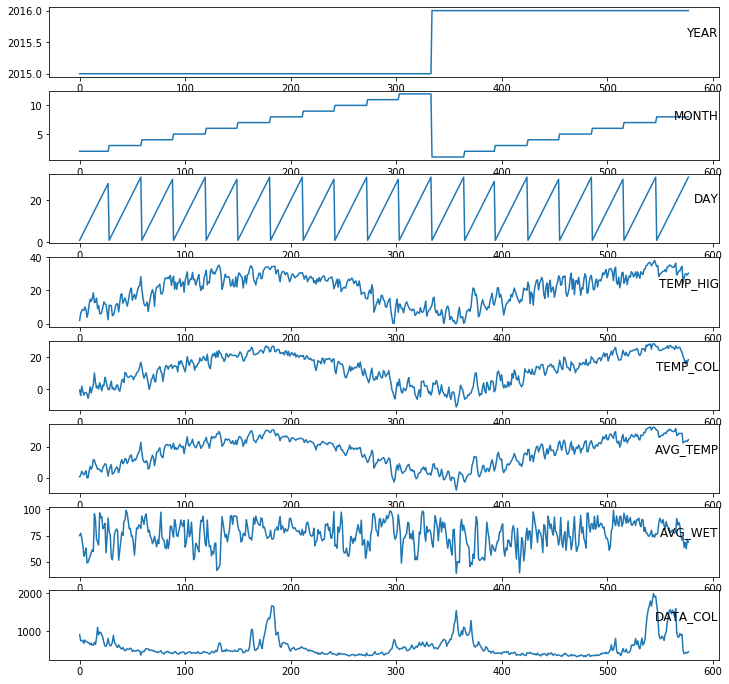

In [220]:
plt.figure(figsize=(12,12))
for i in range(8):
    plt.subplot(8,1,i+1)
    plt.plot(data.values[:,i])
    plt.title(columns[i],y=0.5,loc='right')
plt.show()

## 时间序列数据转化为监督问题数据

In [181]:
def series_to_supervised(data, n_in=1, n_out=1, dropna=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(),list()
    
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names+=[('var%d(t-%d)'%(j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i==0:
            names += [('var%d(t)'%(j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)'%(j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropna:
        agg.dropna(inplace=True)
    return agg

In [182]:
# 数据归一化到0-1之间，无量纲化
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data[['DATA_COL','TEMP_HIG','TEMP_COL','AVG_TEMP','AVG_WET']].values)
# 将时序数据转换为监督问题数据
reframed = series_to_supervised(scaled_data,1,1)
# 删除无用的label数据 因为只需要预测最后一列的数据
reframed.drop(reframed.columns[[6,7,8,9]], axis=1,inplace=True)

In [183]:
reframed.info()
reframed.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577 entries, 1 to 577
Data columns (total 6 columns):
var1(t-1)    577 non-null float64
var2(t-1)    577 non-null float64
var3(t-1)    577 non-null float64
var4(t-1)    577 non-null float64
var5(t-1)    577 non-null float64
var1(t)      577 non-null float64
dtypes: float64(6)
memory usage: 31.6 KB


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.348968,0.049869,0.265823,0.212693,0.599165,0.252829
2,0.252829,0.162730,0.177215,0.236842,0.636743,0.248160
3,0.248160,0.204724,0.326582,0.298142,0.561587,0.260218
4,0.260218,0.223097,0.245570,0.268421,0.446764,0.210043
5,0.210043,0.207349,0.184810,0.239319,0.271399,0.263193


In [184]:
train_days = 400
valid_days = 150
values = reframed.values

In [185]:
values

array([[0.34896842, 0.04986877, 0.26582278, 0.2126935 , 0.59916493,
        0.25282935],
       [0.25282935, 0.16272966, 0.17721519, 0.23684211, 0.63674322,
        0.24816014],
       [0.24816014, 0.20472441, 0.32658228, 0.29814241, 0.56158664,
        0.26021767],
       ...,
       [0.05783669, 0.7847769 , 0.6835443 , 0.77058824, 0.49060543,
        0.06719624],
       [0.06719624, 0.7847769 , 0.73417722, 0.78049536, 0.39039666,
        0.05825848],
       [0.05825848, 0.76902887, 0.70379747, 0.77089783, 0.54070981,
        0.07863936]])

In [186]:
train = values[:train_days, :]
valid = values[train_days:train_days+valid_days,:]
test = values[train_days+valid_days:,:]
train_x, train_y = train[:,:-1], train[:, -1]
valid_x, valid_y = valid[:,:-1], valid[:, -1]
test_x, test_y = test[:, :-1], test[:,-1]

### 将数据集重构为符合LSTM要求的数据格式
### 即[样本数，时间步，特征数]

In [187]:
train_x = train_x.reshape((train_x.shape[0],1,train_x.shape[1]))
valid_x = valid_x.reshape((valid_x.shape[0],1,valid_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0],1,test_x.shape[1]))

In [188]:
train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape, test_y.shape

((400, 1, 5), (400,), (150, 1, 5), (150,), (27, 1, 5), (27,))

## 建立模型并训练

In [189]:
model1 = Sequential([
    keras.layers.LSTM(50, activation='relu', input_shape=(train_x.shape[1], train_x.shape[2])),
    keras.layers.Dense(1, activation='linear')
])

model1.compile(optimizer='adam',
              loss='mean_squared_error',
               metrics=['accuracy']
              )

In [190]:
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                11200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


In [191]:
model_history = model1.fit(train_x, train_y,
                epochs=100,
                batch_size = 32,
                validation_data=(valid_x,valid_y),
                verbose=2,
                shuffle=False)

Train on 400 samples, validate on 150 samples
Epoch 1/100
 - 1s - loss: 0.0322 - accuracy: 0.0000e+00 - val_loss: 0.0472 - val_accuracy: 0.0067
Epoch 2/100
 - 0s - loss: 0.0238 - accuracy: 0.0000e+00 - val_loss: 0.0428 - val_accuracy: 0.0067
Epoch 3/100
 - 0s - loss: 0.0206 - accuracy: 0.0000e+00 - val_loss: 0.0416 - val_accuracy: 0.0067
Epoch 4/100
 - 0s - loss: 0.0196 - accuracy: 0.0000e+00 - val_loss: 0.0410 - val_accuracy: 0.0067
Epoch 5/100
 - 0s - loss: 0.0190 - accuracy: 0.0000e+00 - val_loss: 0.0401 - val_accuracy: 0.0067
Epoch 6/100
 - 0s - loss: 0.0185 - accuracy: 0.0000e+00 - val_loss: 0.0392 - val_accuracy: 0.0067
Epoch 7/100
 - 0s - loss: 0.0179 - accuracy: 0.0000e+00 - val_loss: 0.0382 - val_accuracy: 0.0067
Epoch 8/100
 - 0s - loss: 0.0173 - accuracy: 0.0000e+00 - val_loss: 0.0370 - val_accuracy: 0.0067
Epoch 9/100
 - 0s - loss: 0.0166 - accuracy: 0.0000e+00 - val_loss: 0.0356 - val_accuracy: 0.0067
Epoch 10/100
 - 0s - loss: 0.0159 - accuracy: 0.0000e+00 - val_loss: 0.0

Epoch 84/100
 - 0s - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0133
Epoch 85/100
 - 0s - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0133
Epoch 86/100
 - 0s - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0133
Epoch 87/100
 - 0s - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0133
Epoch 88/100
 - 0s - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0133
Epoch 89/100
 - 0s - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0133
Epoch 90/100
 - 0s - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0133
Epoch 91/100
 - 0s - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0133
Epoch 92/100
 - 0s - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0133
Epoch 93/100
 - 0s - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0133
Epoch 94/1

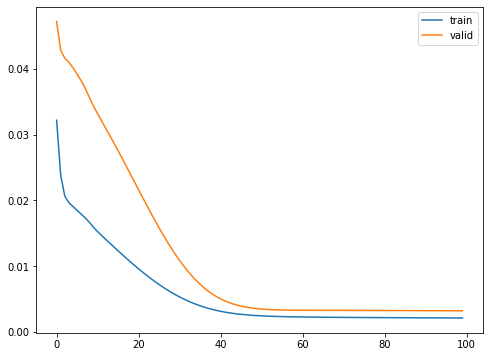

In [192]:
plt.figure(figsize=(8,6))
plt.plot(model_history.epoch, model_history.history['loss'], label='train')
plt.plot(model_history.epoch, model_history.history['val_loss'], label='valid')
plt.legend()
plt.show()

## 模型预测&可视化

In [197]:
train_predict = model1.predict(train_x)
valid_predict = model1.predict(valid_x)
test_predict = model1.predict(test_x)

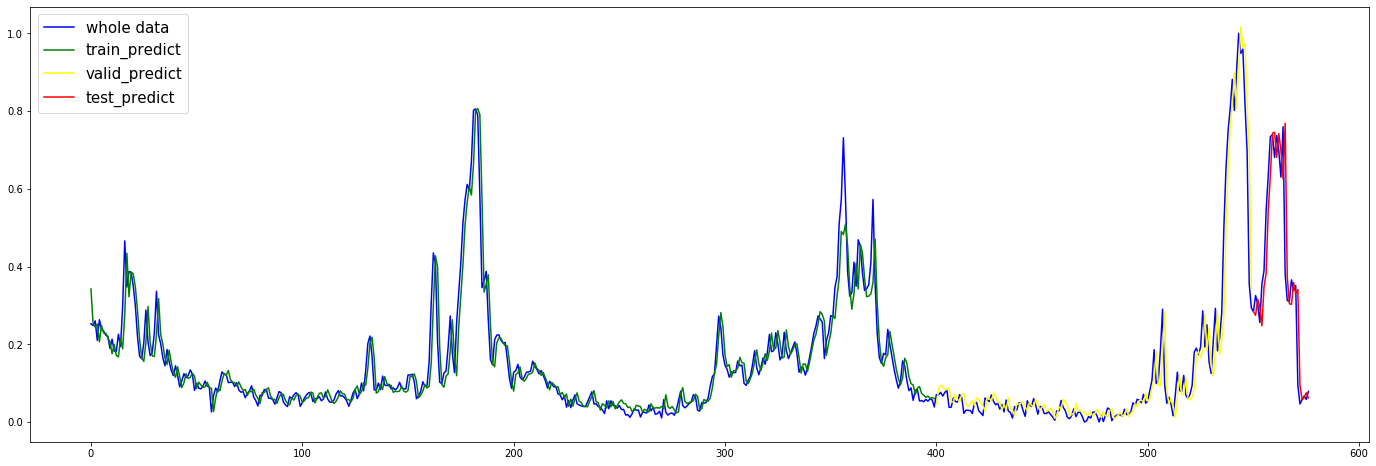

In [198]:
plt.figure(figsize=(24,8))
plt.plot(values[:,-1], color='blue', label='whole data')
plt.plot([x for x in train_predict], color='green', label='train_predict')
plt.plot([None for _ in train_predict]+[x for x in valid_predict], color='yellow', label='valid_predict')
plt.plot([None for _ in train_predict]+[None for _ in valid_predict]+[x for x in test_predict], color='red', label='test_predict')
plt.legend(fontsize=15)
plt.show()

In [200]:
model1.evaluate(test_x, test_y)

27/27 [==============================] - 0s 407us/step


[0.011687224730849266, 0.0]

In [201]:
data.head()
len(data)

578

In [223]:
origin_data=np.array(data[train_days+valid_days:,6])
origin_data

TypeError: '(slice(550, None, None), 6)' is an invalid key

In [225]:
data[train_days+valid_days:][""]

KeyError: 6

In [203]:
for i in range(4):
    test_predict=np.column_stack((test_predict,np.zeros(27)))
test_predict.shape

(27, 5)

In [204]:
test_predict

array([[0.28400955, 0.        , 0.        , 0.        , 0.        ],
       [0.27445358, 0.        , 0.        , 0.        , 0.        ],
       [0.3161231 , 0.        , 0.        , 0.        , 0.        ],
       [0.29551327, 0.        , 0.        , 0.        , 0.        ],
       [0.24755612, 0.        , 0.        , 0.        , 0.        ],
       [0.34711108, 0.        , 0.        , 0.        , 0.        ],
       [0.38268378, 0.        , 0.        , 0.        , 0.        ],
       [0.54356235, 0.        , 0.        , 0.        , 0.        ],
       [0.63379925, 0.        , 0.        , 0.        , 0.        ],
       [0.74320799, 0.        , 0.        , 0.        , 0.        ],
       [0.74537152, 0.        , 0.        , 0.        , 0.        ],
       [0.68109256, 0.        , 0.        , 0.        , 0.        ],
       [0.7418173 , 0.        , 0.        , 0.        , 0.        ],
       [0.69702864, 0.        , 0.        , 0.        , 0.        ],
       [0.62560749, 0.        , 0.

In [212]:
inverse_test_predict = scaler.inverse_transform(test_predict)

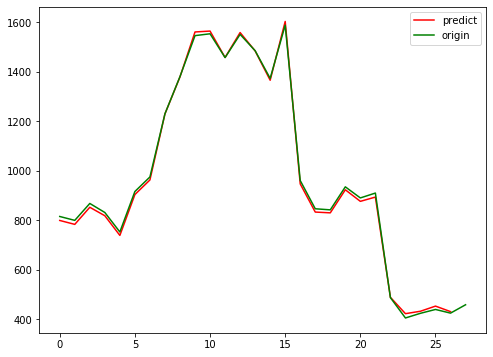

In [216]:
plt.figure(figsize=(8,6))
plt.plot(inverse_test_predict[:,0],color='r',label='predict')
plt.plot(origin_data,color='g',label='origin')
plt.legend()
plt.show()